# Churn model
Import the libraries that will be useful for the model

In [1]:
# Libraries for manipulate the data
import numpy as np
import pandas as pd
# Libraries for plot the data
import matplotlib.pyplot as plt
import seaborn as sns
# Libraries for the model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, auc, classification_report, precision_recall_curve, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, plot_precision_recall_curve
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_columns', None)

In [2]:
# Read the data
df = pd.read_csv('../Data_df/Telco-Customer-Churn.csv')
df_churn = pd.read_csv('../Data_df/Churn data.csv')
# Drop the customerID 
df = df.drop(columns='customerID')
# take a sample of the data
df.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3409,Female,1,Yes,No,70,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,113.65,7714.65,No
2129,Male,0,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.30,75.3,Yes
6542,Male,0,No,No,15,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,76.00,1130.85,Yes
3188,Female,0,No,No,8,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,49.85,365.55,Yes
787,Female,0,Yes,No,34,Yes,Yes,DSL,Yes,No,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),60.85,2003.6,No


## Exploratory data analysis
In the dataset, each row represents a customer, each column contains customer’s attributes.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents.

In [3]:
# See information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


#### Fix the data types and change the target

In [4]:
# The target need to be a numeric columns
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [5]:
# Pass total charges to numeric
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
# Pass the churn column to numeric
df['Churn'] = df.Churn.replace({'No': 0, 'Yes': 1})

#### See the nulls of the dataset
Only 11 values in the columns TotalCharges are nulls. Because the proportion of nulls is realy little, I will drop the rows with nulls.

In [6]:
# Check the nulls
display(df.isna().sum())
# Drop null values
df = df.dropna()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

#### See the unique values in the different columns.
In the dataset we have too much categorical columns

In [7]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

Generate descriptive statistics for all the numeric columns

In [8]:
# Apply the describe method to all the numeric columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


### Plotting the variables
#### Pie plot of the churn variables

The dataset has 26.6% of churn cases and the rest of the data is client that didn't leave the company

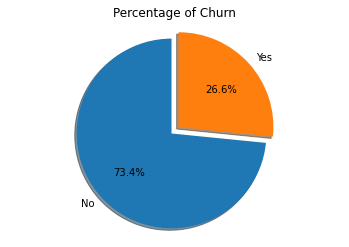

In [9]:
fig1, ax1 = plt.subplots()

ax1.set_title('Percentage of Churn')

ax1.pie(df.Churn.value_counts(normalize=True), explode=[0,0.1], labels=['No', 'Yes'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

#### Barplot with the categorical columns and the target

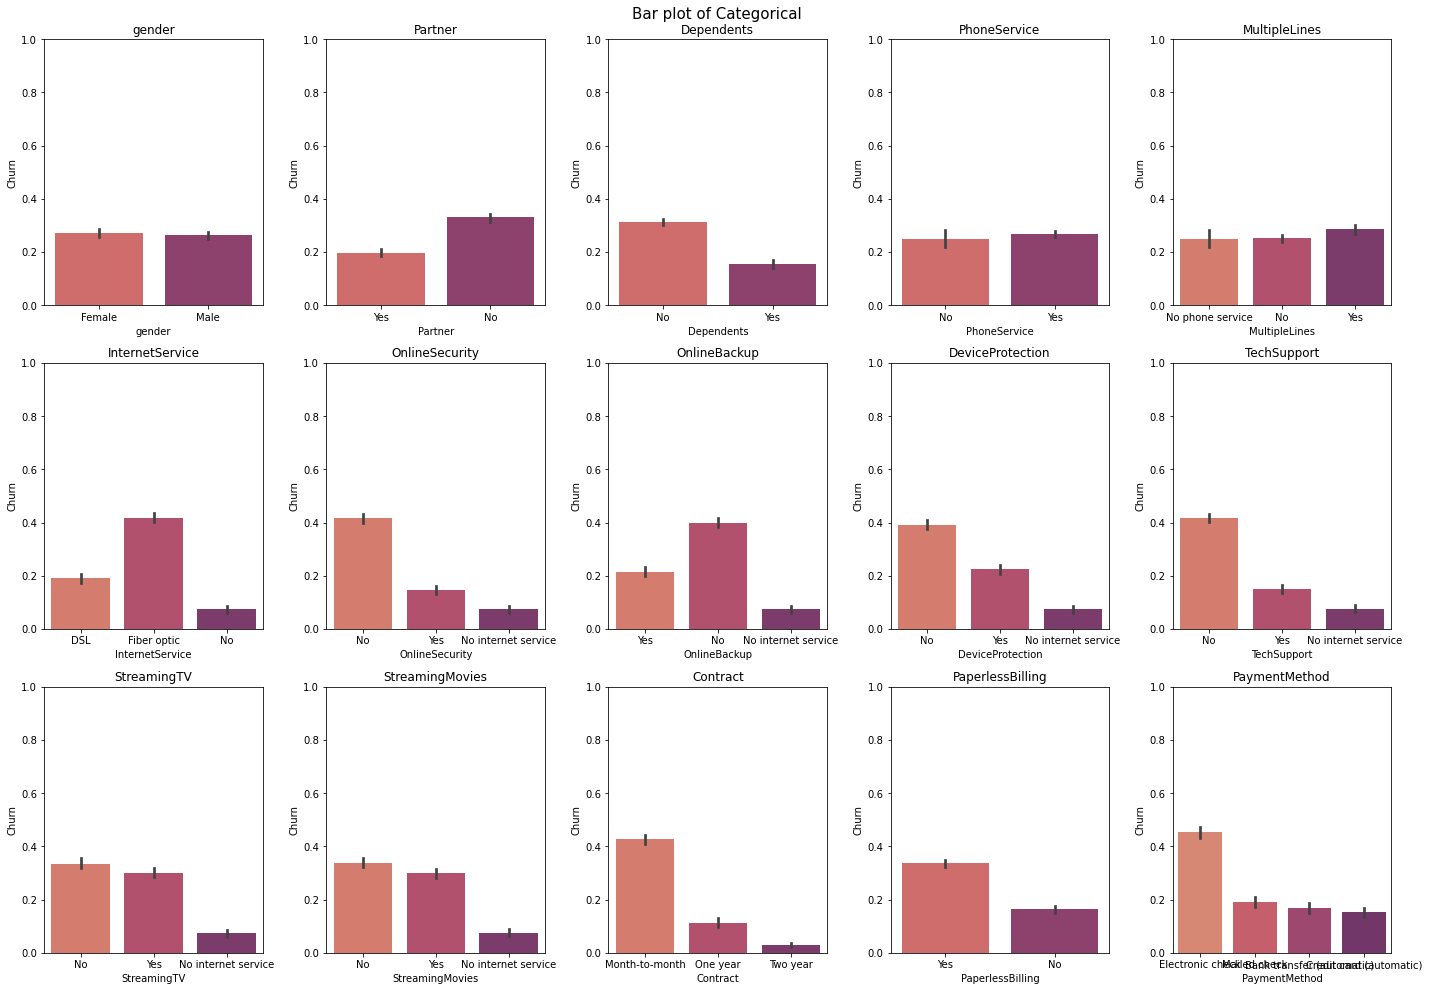

In [10]:
# Make a plot with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,14))
# Add the title
fig.suptitle('Bar plot of Categorical', fontsize=15)
# Plot each categorical columns with the churn proportion in each plot
for column, ax in zip(df.select_dtypes(object), axes.flatten()):
    sns.barplot(x=column, y="Churn", data=df, ax=ax, palette="flare")
    # Set the y limit
    ax.set_ylim(0,1)
    # Set the title for the subplot
    ax.set_title(column)
    
# Fix the plot
fig.tight_layout()

#### Histogram of the numeric columns

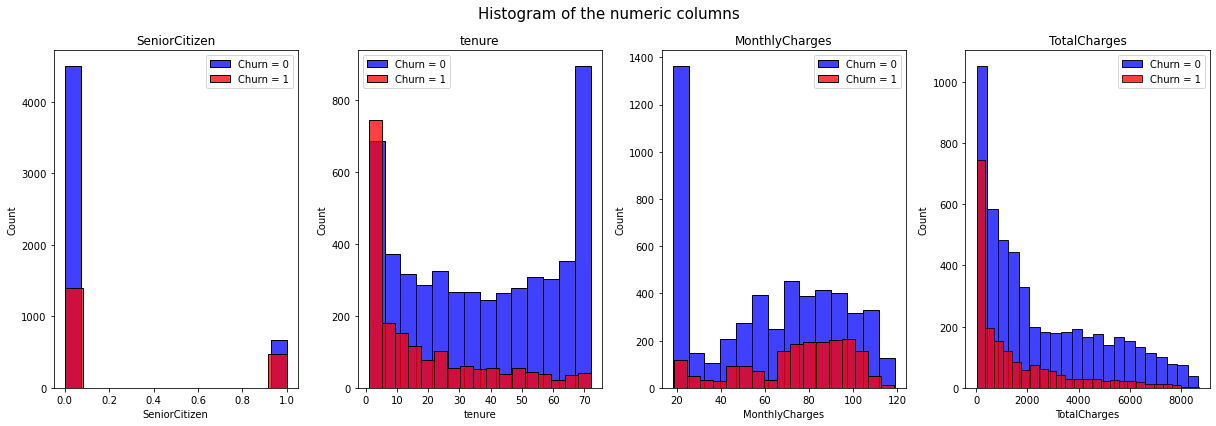

In [11]:
# Make a plot with 1 rows and 4 columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17,6))
# Add the title
fig.suptitle('Histogram of the numeric columns', fontsize=15)
# Plot each categorical columns with the churn proportion in each plot
for column, ax in zip(df.select_dtypes(np.number).drop(columns='Churn'), axes.flatten()):
    sns.histplot(x=column, data=df[df['Churn']==0], ax=ax, color="blue")
    sns.histplot(x=column, data=df[df['Churn']==1], ax=ax, color="red")
    # Set the legend
    ax.legend(['Churn = 0', 'Churn = 1'])
    # Set the title
    ax.set_title(column)

# Fix the plot
fig.tight_layout()

#### Correlation between variables and the target

<AxesSubplot:>

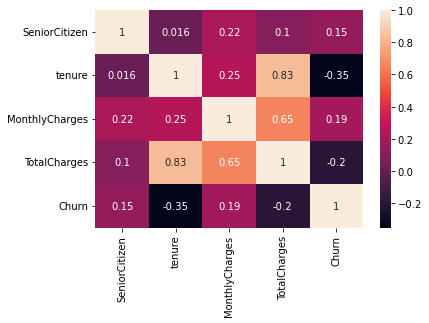

In [12]:
# Check with the heatmap the correlation of the numeric variables
sns.heatmap(df.corr(), annot=True)

#### Correlation with all the variables against the target
Add the categorical variables and take the correlation

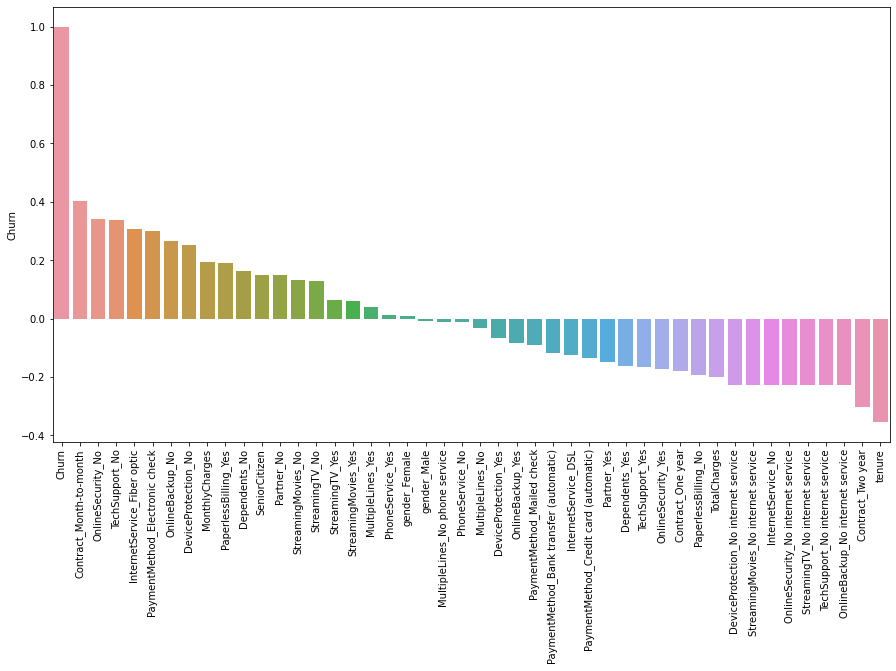

In [13]:
#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df)
# Take the correlation of all the variables with the target, the churn column.
correlation = df_dummies.corr()['Churn'].sort_values(ascending = False)
# Make the  figure
plt.figure(figsize=(15,8))
# Do a barplot with the correlation
sns.barplot(x=correlation.index, y=correlation)
# Rotate the x axis
plt.xticks(rotation=90)
plt.show()

## MODEL
First, split the data in two variables:
* The X variable with the features.
* The y variable with the target.

In [14]:
X = df.drop(columns='Churn')
y = df.Churn

Now, split the data in train and test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
y_train.value_counts(normalize=True)

0    0.734222
1    0.265778
Name: Churn, dtype: float64

### Train the models
To train the models, I choose 3 algoritms:
1. Logistic Regression.
2. Random Forest Classifier.
3. Gradient Boosting for Classification, XGBoost.

I will perform a random search to select the best model and then I will retrain the best model to improve the performance.

The metrics that I choose in this problems is the f1-score because the data is not balance, this metrics help to deal with thtat and the accuracy score will be skewed.

In [17]:
# Make a columns transformer to treat the variables.
# For the categorical columns, I pass to dummy variables
# For the numeric columns, I normalize the data.
tranformer = ColumnTransformer([
    ("numeric",StandardScaler(),make_column_selector(dtype_include=np.number)),
    ("encoder",OneHotEncoder(handle_unknown="ignore"),make_column_selector(dtype_exclude=np.number))],
    remainder="passthrough")

# Create the pipeline, with the tranformer and the model
pipeline_churn = Pipeline([
    ('StandarEncoder', tranformer),
    ("model",LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Create the parameters for the different models
parameters = [
    {
        "model__C": np.linspace(0.001,10,30),
        "model__fit_intercept": [True,False],
        'model__penalty':['l1', 'l2'],
        "model__class_weight": [None,"balanced"]
    },
    {
        "model":[RandomForestClassifier()],
        "model__max_depth": np.arange(2, 10, 1),
        "model__n_estimators": np.arange(25,750,50),
        "model__class_weight": [None,"balanced", "balanced_subsample"]
    },
    {
        "model":[XGBClassifier(use_label_encoder=False)],
        "model__n_estimators": np.arange(50, 750, 50), 
        "model__max_depth": np.arange(2, 10, 1),
        'model__lambda': [0.5,0.75,1,1.5],
        'model__alpha': [0,0.5,0.75,1,1.5]
    }
]

# Create the cross validation partition
cv = KFold(3, shuffle=True, random_state=42)

Create the random search to select the best model with cross validation and the different parameters.

In [18]:
warnings.filterwarnings('ignore')
# Create the random search
ramd_grid = RandomizedSearchCV(pipeline_churn, parameters, scoring="f1", n_jobs=-1, cv=cv, n_iter=200, verbose=1, random_state=42)
# Train the random search
ramd_grid.fit(X_train,y_train)
# Get the result
resultados = pd.DataFrame(ramd_grid.cv_results_).sort_values("rank_test_score")

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [19]:
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_depth,param_model__class_weight,param_model,param_model__lambda,param_model__alpha,param_model__penalty,param_model__fit_intercept,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
128,12.739349,0.482634,1.035381,0.030081,675,7,balanced_subsample,RandomForestClassifier(class_weight='balanced_...,NaN,NaN,NaN,NaN,NaN,"{'model__n_estimators': 675, 'model__max_depth...",0.627483,0.633981,0.645620,0.635695,0.007503,1
79,11.659289,0.105212,0.739473,0.058334,575,8,balanced_subsample,RandomForestClassifier(class_weight='balanced_...,NaN,NaN,NaN,NaN,NaN,"{'model__n_estimators': 575, 'model__max_depth...",0.625850,0.635417,0.640065,0.633777,0.005918,2
194,5.384611,0.034843,0.482385,0.009085,375,8,balanced,RandomForestClassifier(class_weight='balanced_...,NaN,NaN,NaN,NaN,NaN,"{'model__n_estimators': 375, 'model__max_depth...",0.622979,0.636443,0.641755,0.633725,0.007902,3
196,7.976267,0.199893,0.574124,0.016776,475,7,balanced_subsample,RandomForestClassifier(class_weight='balanced_...,NaN,NaN,NaN,NaN,NaN,"{'model__n_estimators': 475, 'model__max_depth...",0.623058,0.632997,0.645008,0.633688,0.008974,4
199,2.546307,0.076604,0.236531,0.033468,125,8,balanced_subsample,RandomForestClassifier(class_weight='balanced_...,NaN,NaN,NaN,NaN,NaN,"{'model__n_estimators': 125, 'model__max_depth...",0.626486,0.632404,0.641815,0.633568,0.006312,5


The model has a good performance in the first cross validation train with the tree models. The best algorithm is Random Forest Classifier with an average f1 score of 0.63 in the cross validation.

With respect to the model metrics, the f1-score for the positive label is equal to 0.68 and for the label 0 is equal to 0.84. Also, the accuracy of the model is 0.79, this means that the model predicts well 79% of the times. As well as, the recall is 0.84 this means that the model captures 84% of churn cases. Finally, the precision is equal to 0.57, meaning that the model for each prediction that is equal to churn is correct 57% of the times.

In [20]:
y_pred_train = ramd_grid.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      4130
           1       0.57      0.84      0.68      1495

    accuracy                           0.79      5625
   macro avg       0.75      0.80      0.76      5625
weighted avg       0.83      0.79      0.80      5625



### Confusion matrix
The model predict well the 0 label in 3239 times and label 1 in 1279 times, this are the true negativa and the true postive respectively. With regard to the false negatives this are equal to 216 in the train set and the false positives are equal to 891.

<AxesSubplot:>

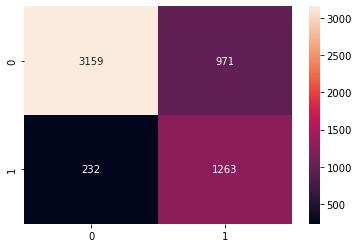

In [21]:
# Create the confusion matrix for the train set
sns.heatmap(confusion_matrix(y_train,y_pred_train), annot=True, fmt="d")

# Train the best model, Random Forest Classifier
I will retrain the best model to improve the performance. For that, I will add 2 steps more in the pipeline:
1. The first one, is a features selection step to keep the most relevant variables.
2. The second one, is to reduce the dimensionality of the dataset through PCA.

Then for the random forest model, I will add more values to the hyperparameters.

In [22]:
# View the best model in the last random search
ramd_grid.best_params_

{'model__n_estimators': 675,
 'model__max_depth': 7,
 'model__class_weight': 'balanced_subsample',
 'model': RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                        n_estimators=675)}

In [23]:
# Create the pipeline with the 4 steps
pipeline_rf = Pipeline([
    ('StandarEncoder', tranformer),
    ("features_selection",RFE(LogisticRegression(), step = 1)),
    ("reduction",PCA(0.8)),
    ("model",RandomForestClassifier(class_weight='balanced'))
])
# Create the parameters for the pipeline
parameters_rf = [
    {
        "features_selection":[RFE(RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=275), step = 1),
                              SelectFromModel(RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=275)), 
                              None],
        "reduction": [PCA(0.9), PCA(0.8), None],
        "model__max_depth": np.arange(4, 12, 1),
        "model__n_estimators":np.arange(300,900,10),
        "model__max_features": ['auto', 'sqrt', 'log2']
    }]

In [24]:
# Create the random search for the model
ramd_grid_rf = RandomizedSearchCV(pipeline_rf, parameters_rf, scoring="f1", n_jobs=-1, cv=cv, n_iter=150, verbose=1)
# Train the model
ramd_grid_rf.fit(X_train,y_train)
# Get the results
resultados = pd.DataFrame(ramd_grid_rf.cv_results_).sort_values("rank_test_score")
resultados.head()

Fitting 3 folds for each of 150 candidates, totalling 450 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reduction,param_model__n_estimators,param_model__max_features,param_model__max_depth,param_features_selection,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
86,14.022488,0.515145,1.432971,0.230939,None,840,log2,7,None,"{'reduction': None, 'model__n_estimators': 840...",0.625205,0.634761,0.647105,0.635690,0.008965,1
14,130.648247,0.330032,0.817935,0.101589,PCA(n_components=0.9),480,auto,7,RFE(estimator=RandomForestClassifier(class_wei...,"{'reduction': PCA(n_components=0.9), 'model__n...",0.621277,0.648794,0.635135,0.635068,0.011234,2
49,125.462912,0.334161,1.245524,0.200746,None,760,auto,7,RFE(estimator=RandomForestClassifier(class_wei...,"{'reduction': None, 'model__n_estimators': 760...",0.625624,0.635672,0.643770,0.635022,0.007422,3
51,10.015199,0.308813,0.775588,0.080045,None,370,auto,7,SelectFromModel(estimator=RandomForestClassifi...,"{'reduction': None, 'model__n_estimators': 370...",0.631491,0.636756,0.636511,0.634919,0.002426,4
7,11.562279,1.410689,0.785680,0.003522,None,310,log2,7,SelectFromModel(estimator=RandomForestClassifi...,"{'reduction': None, 'model__n_estimators': 310...",0.632464,0.635004,0.637168,0.634879,0.001922,5


In [26]:
# Show the best params in the random search. 
ramd_grid_rf.best_params_

{'reduction': None,
 'model__n_estimators': 840,
 'model__max_features': 'log2',
 'model__max_depth': 7,
 'features_selection': None}

The model metrics in the training set, the f1-score for the positive label is equal to 0.67 and for the label 0 is equal to 0.84. Also, the accuracy of the model is 0.78, this means that the model predicts well 78% of the times. As well as the recall is 0.84 this means that the model captures 84% of churn cases. Finally, the precision is equal to 0.56, meaning that the model for each prediction that is equal to churn is correct 56% of the times.

In [27]:
# Get the performance of the model in the train set
y_pred_train_rf = ramd_grid_rf.predict(X_train)
print(classification_report(y_train, y_pred_train_rf))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      4130
           1       0.56      0.84      0.67      1495

    accuracy                           0.78      5625
   macro avg       0.75      0.80      0.76      5625
weighted avg       0.83      0.78      0.79      5625



In the test set the metrics are very similar to the training set, this mean that the model doesn't overfit, the variance of the model is low. The f1-score for the positive label is equal to 0.62 and for the label 0 is equal to 0.80. Also, the accuracy of the model is 0.74, this means that the model predicts well 74% of the times. As well as the recall is 0.78 this means that the model captures 78% of churn cases. Finally, the precision is equal to 0.51, meaning that the model for each prediction that is equal to churn is correct 51% of the times.

In [28]:
# Get the performance of the model in the test set
y_pred_test_rf = ramd_grid_rf.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



### Confusion matrix
The model predict well the 0 label in 3239 times and label 1 in 1279 times, this are the true negativa and the true postive respectively. With regard to the false negatives this are equal to 216 in the train set and the false positives are equal to 891.

<AxesSubplot:>

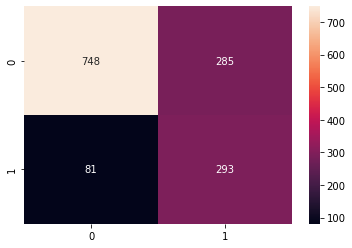

In [29]:
# Create the confusion matrix for the test set
sns.heatmap(confusion_matrix(y_test,y_pred_test_rf),annot=True,fmt="d")